In [1]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic.v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import START, END, StateGraph
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [2]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
llm = ChatGroq(model="gemma2-9b-it")

c:\Repos\QMigrator_AI\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
urls = [
    "https://www.javatpoint.com/java-tutorial",
    "https://www.javatpoint.com/history-of-java",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [d for doc in docs for d in doc]


text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=5
)
spiltted_docs = text_splitter.split_documents(docs_list)

vector_store = Chroma.from_documents(
    documents=spiltted_docs, collection_name="rag-agent", embedding=embeddings
)

retriever = vector_store.as_retriever()

pdf_loader = PyPDFLoader("C:/Repos/QMigrator_AI/Practice/Langgraph/Siva-pdf504504.pdf")
pdf_docs = pdf_loader.load()

pdf_text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=5)
pdf_spiltted_docs = pdf_text_splitter.split_documents(pdf_docs)
pdf_vector_store = Chroma.from_documents(
    documents=pdf_spiltted_docs, collection_name="pdf-retrieve", embedding=embeddings
)
pdf_retriever = pdf_vector_store.as_retriever()
# pdf_retriever.invoke('Working as Technical Analyst in Quadrant Technologies from which date?')

In [4]:
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_javainfo",
    description="Search for information about Java. For any questions about Java, you must use this tool!",
)

pdf_tool = create_retriever_tool(
    retriever=pdf_retriever,
    name="pdf_retriever",
    description="Search for the Information from PDF documents. For any questions about PDF, you must use this tool!",
)
# tools =  [retriever_tool]
tools = [retriever_tool, pdf_tool]

In [5]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


class grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")


def grade_documents(state: AgentState):
    llm_with_structure_op = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    chain = prompt | llm_with_structure_op

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score
    print("score in Grade Documents ", score)
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter"


def ai_asssitant(state: AgentState):
    print("CALL AGENT AI Assitance....")
    messages = state["messages"]
    print("initla query in ai assistant ", messages)
    llm_with_tool = llm.bind_tools(tools)
    print("LLM WITH TOOL ", llm_with_tool)
    response = llm_with_tool.invoke(messages)
    print("response of in ai assistant from llm with tools", response)
    return {"messages": [response]}


def generate(state: AgentState):
    print("GENERATE Based on the Relevent Docs fetched from the Retriever....")
    messages = state["messages"]
    print("Messages in Generate ", messages)
    question = messages[0].content
    print("Question ", question)
    last_message = messages[-1]
    docs = last_message.content
    print("Content ", docs)
    prompt = hub.pull("rlm/rag-prompt")
    rag_chain = prompt | llm | StrOutputParser()
    response = rag_chain.invoke({"context": docs, "question": question})
    print("Response in Generate ", response)
    return {"messages": [response]}


def rewrite(state: AgentState):
    print("TRANSFORM QUERY....")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]
    response = llm.invoke(msg)
    return {"messages": [response]}

In [6]:
# retriever_node = ToolNode([retriever_tool])
retriever_node = ToolNode([retriever_tool, pdf_tool])

In [7]:
flow = StateGraph(AgentState)
flow.add_node("AI Assistant", ai_asssitant)
flow.add_node("Retriever", retriever_node)
flow.add_node("Rewrite", rewrite)
flow.add_node("Generate", generate)

In [8]:
flow.add_edge(START, "AI Assistant")
flow.add_conditional_edges(
    "AI Assistant", tools_condition, {"tools": "Retriever", END: END}
)

In [9]:
flow.add_conditional_edges(
    "Retriever", grade_documents, {"rewriter": "Rewrite", "generator": "Generate"}
)

In [10]:
flow.add_edge("Generate", END)
flow.add_edge("Rewrite", "AI Assistant")

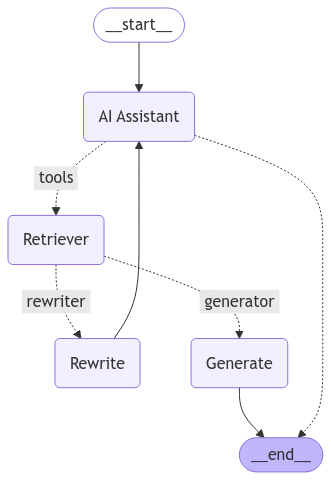

In [11]:
app = flow.compile()
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
app.invoke({"messages": ["What is Java?"]})

CALL AGENT AI Assitance....
initla query in ai assistant  [HumanMessage(content='What is Java?', additional_kwargs={}, response_metadata={}, id='6c39846a-e867-42b4-9ee3-a32d6a42e324')]
LLM WITH TOOL  bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000026859BAFBE0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000026859BBD8B0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********')) kwargs={'tools': [{'type': 'function', 'function': {'name': 'retrieve_javainfo', 'description': 'Search for information about Java. For any questions about Java, you must use this tool!', 'parameters': {'properties': {'query': {'description': 'query to look up in retriever', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'pdf_retriever', 'description': 'Search for the Information from PDF documents. For any questions about PDF, you must use this tool!', 'paramete

c:\Repos\QMigrator_AI\.venv\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Response in Generate  Java is a high-level, robust, object-oriented and secure programming language.  It is a platform that was developed by Sun Microsystems (now Oracle) and is widely used for internet programming.  Java was originally called Oak before being renamed.  





{'messages': [HumanMessage(content='What is Java?', additional_kwargs={}, response_metadata={}, id='6c39846a-e867-42b4-9ee3-a32d6a42e324'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jdf7', 'function': {'arguments': '{"query":"What is Java?"}', 'name': 'retrieve_javainfo'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1099, 'total_tokens': 1185, 'completion_time': 0.156363636, 'prompt_time': 0.044504241, 'queue_time': 0.020655127999999995, 'total_time': 0.200867877}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5624866e-02dd-4d20-ab4d-bda417d9128d-0', tool_calls=[{'name': 'retrieve_javainfo', 'args': {'query': 'What is Java?'}, 'id': 'call_jdf7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1099, 'output_tokens': 86, 'total_tokens': 1185}),
  ToolMessage(content='get() methodJava Instant getLong() methodJava Insta

In [13]:
app.invoke({"messages": ["who is a current prime minister of india?"]})

CALL AGENT AI Assitance....
initla query in ai assistant  [HumanMessage(content='who is a current prime minister of india?', additional_kwargs={}, response_metadata={}, id='417d3a0d-bfef-4982-a0d9-f92d23e51ce2')]
LLM WITH TOOL  bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000026859BAFBE0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000026859BBD8B0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********')) kwargs={'tools': [{'type': 'function', 'function': {'name': 'retrieve_javainfo', 'description': 'Search for information about Java. For any questions about Java, you must use this tool!', 'parameters': {'properties': {'query': {'description': 'query to look up in retriever', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'pdf_retriever', 'description': 'Search for the Information from PDF documents. For any questions about PDF, you mus

{'messages': [HumanMessage(content='who is a current prime minister of india?', additional_kwargs={}, response_metadata={}, id='417d3a0d-bfef-4982-a0d9-f92d23e51ce2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_k3nk', 'function': {'arguments': '{"query":"Who is the current prime minister of India?"}', 'name': 'retrieve_javainfo'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1104, 'total_tokens': 1193, 'completion_time': 0.161818182, 'prompt_time': 0.068515, 'queue_time': 0.021477702999999987, 'total_time': 0.230333182}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1ad7bff6-e5a8-48c9-92b8-68142e4e7052-0', tool_calls=[{'name': 'retrieve_javainfo', 'args': {'query': 'Who is the current prime minister of India?'}, 'id': 'call_k3nk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1104, 'output_tokens': 89, 'total_tokens

In [14]:
app.invoke(
    {
        "messages": [
            "Working as Technical Analyst in Quadrant Technologies from which date?"
        ]
    }
)

CALL AGENT AI Assitance....
initla query in ai assistant  [HumanMessage(content='Working as Technical Analyst in Quadrant Technologies from which date?', additional_kwargs={}, response_metadata={}, id='41254b72-3a5a-4452-af06-512d0e42ce6f')]
LLM WITH TOOL  bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000026859BAFBE0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000026859BBD8B0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********')) kwargs={'tools': [{'type': 'function', 'function': {'name': 'retrieve_javainfo', 'description': 'Search for information about Java. For any questions about Java, you must use this tool!', 'parameters': {'properties': {'query': {'description': 'query to look up in retriever', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'pdf_retriever', 'description': 'Search for the Information from PDF documents. For any

{'messages': [HumanMessage(content='Working as Technical Analyst in Quadrant Technologies from which date?', additional_kwargs={}, response_metadata={}, id='41254b72-3a5a-4452-af06-512d0e42ce6f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7qfy', 'function': {'arguments': '{"query":"Working as Technical Analyst in Quadrant Technologies from which date?"}', 'name': 'retrieve_javainfo'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1106, 'total_tokens': 1199, 'completion_time': 0.169090909, 'prompt_time': 0.035493966, 'queue_time': 0.022564313999999995, 'total_time': 0.204584875}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-32815561-7561-407a-9e75-b5593250c81e-0', tool_calls=[{'name': 'retrieve_javainfo', 'args': {'query': 'Working as Technical Analyst in Quadrant Technologies from which date?'}, 'id': 'call_7qfy', 'type': '